In [1]:
# Importing Necessary Library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime, timedelta
import gcsfs

pd.set_option('display.max_columns', None)

In [2]:
# Over 3 years of Demand data from EDW (2022.01-2024.10)
# HA (Company Code) / All customer type
# EDW data includes date, parts number, division code, item description, order qty and customer type

folder_path = 'gs://scm_dataset/EO_early/'

fs = gcsfs.GCSFileSystem()
file_list = fs.glob(f'{folder_path}*.xlsx')

if file_list:
    file_path = file_list[0]
    df_eo = pd.read_excel(fs.open(file_path), header=3, usecols="B:G")
else:
    print("No files found in the specified folder.")

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
df_eo.head(2)

,Order Month-YYYYMM,Parts No,Division Code,Item Description,Order Qty,Ship To Customer Type
0,202201,0CZZA10001J,DGT,"Capacitor,Film,Box",1,Repair SVC Center
1,202201,0CZZA20001L,DGT,"Capacitor,Film,Box",1,OEM


In [4]:
# GERP data will give the registration date, grade, item status (detailed part information)

folder_path = 'gs://scm_dataset/GERP_Master/new_gerp_master/'
file_list = fs.glob(f'{folder_path}*.xlsx')

if file_list:
    file_path = file_list[0]
    df_gerp = pd.read_excel(fs.open(file_path), sheet_name='Data', header=1, usecols="A:AM")
else:
    print("No files found in the specified folder.")

In [5]:
df_gerp2 = df_gerp[['Part', 'Desc', 'Item status', 'parts_grade', 'creation_date']]
df_gerp2.head(2)

,Part,Desc,Item status,parts_grade,creation_date
0,0CBZTBU002B,"Capacitor,Film,Box",Active,D,2014.07.12
1,0CBZTBU002C,"Capacitor,Film,Box",Active,D,2016.01.10


In [6]:
# Sub part data (Substitute part information to the original part)

folder_path = 'gs://scm_dataset/Sub_master/Tasha_sub/'
file_list = fs.glob(f'{folder_path}*.xlsx')

if file_list:
    file_path = file_list[0]
    df_sub = pd.read_excel(fs.open(file_path), sheet_name='Sub Master Inventory', header=1, usecols="A:P")
else:
    print("No files found in the specified folder.")

In [7]:
# This sub data is used to link the original part and sub part

df_sub[df_sub['original_part'] == '0CZZW1H001X']

,original_part,description,sub_part,sub inventory,eta,bo_asc,bo_dms,bo_other,sub transit,sub open,OP AIR,OP TRK,OP SEA,ETA 4 weeks,Sub RA,Sub Y/N
33011,0CZZW1H001X,"Capacitor,High Voltage",0CZZW1H004K,0,10/14_120 ; 11/05_74,0,0,1,194,17,0,0,17,120,0,Y
34452,0CZZW1H001X,"Capacitor,High Voltage",AGF76815310,0,0,0,0,0,0,0,0,0,0,0,0,Y


In [8]:
!pip install msoffcrypto-tool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 6.3 MB/s eta 0:00:00


In [9]:
# SPM Data

import msoffcrypto
from io import BytesIO
import gcsfs
import pandas as pd

folder_path = 'gs://scm_dataset/SPM_ALL/NEW_SPM_ALL_GCP/'
password = '1'

file_list = fs.glob(f'{folder_path}*.xlsx')

if file_list:
    file_path = file_list[0]

    with fs.open(file_path, 'rb') as file:
        # Create a msoffcrypto office file object
        office_file = msoffcrypto.OfficeFile(file)
        office_file.load_key(password=password)

        # Decrypt the file
        decrypted_file = BytesIO()
        office_file.decrypt(decrypted_file)

        # Read the decrypted file with pandas
        decrypted_file.seek(0)  # Move cursor to the beginning
        df_spm = pd.read_excel(
            decrypted_file,
            engine='openpyxl',  # Use openpyxl for .xlsx files
            sheet_name='SPM_Recommand',  # Specify the sheet name
            header=1,  # Use the third row as the header (index 2)
            skiprows=1,  # Start reading from the fourth row
        )
else:
    print("No files found in the specified folder.")

In [10]:
df_spm.head(2)

,CONCAN (with Part No),CK,Recmd Date,Subsidiary,Rep. Part No,Part No.,Desc.,Part Spec,Model,Div_Cd,Class Code,Part Reg Date,Ref Price,Currency,USD Price,Sku Active,Sku Cust4,Sku Cust7,Isas litem,PMP Flag,Part_type_code,EDW Grade,M12 Amt,M12 Cnt,M11 Amt,M11 Cnt,M10 Amt,M10 Cnt,M9 Amt,M9 Cnt,M8 Amt,M8 Cnt,M7 Amt,M7 Cnt,M6 Amt,M6 Cnt,M5 Amt,M5 Cnt,M4 Amt,M4 Cnt,M3 Amt,M3 Cnt,M2 Amt,M2 Cnt,M1 Amt,M1 Cnt,M3 Amt Adj,M2 Amt Adj,M1 Amt Adj,FCST Amt,LT,Seteoq,ROP,Stock Max,Avail QTY,Subst. Avail,Back Order,On Order,Subst Onorder,In Repair,Air Ord,Air Transit,Sea Ord,Sea Transit,Avail Day,Shortage Date,Repl Amount,Replrec Amount,Repl Subst Amount,Repl Bal Amount,Repl Origin,Origin,Origin Org Avail,Depot Org Avail,Depot Subst Avail,Aver_12M_S,12M_S_TO,Aver_6M_S,6M_S_TO,Aver_3M_S,3M_S_TO,P_W1_WEEK,~04 Nov,2024-11-04 00:00:00,2024-11-11 00:00:00,2024-11-18 00:00:00,2024-11-25 00:00:00,2024-12-02 00:00:00,2024-12-09 00:00:00,2024-12-16 00:00:00,2024-12-23 00:00:00,2024-12-30 00:00:00,2024-01-06 00:00:00,SO_ALLOCATED,SO_PACKING,SO_WH_SHIPPED,SO_BACKORDER,SO_RFRESERVE,~04 Nov.1,2024-11-04 00:00:00.1,2024-11-11 00:00:00.1,2024-11-18 00:00:00.1,2024-11-25 00:00:00.1,2024-12-02 00:00:00.1,2024-12-09 00:00:00.1,2024-12-16 00:00:00.1,2024-12-23 00:00:00.1,2024-12-30 00:00:00.1,2024-01-06 00:00:00.1,2024-01-13 00:00:00,2024-01-20 00:00:00,2024-01-27 00:00:00,2024-11-04 00:00:00.2,2024-11-11 00:00:00.2,2024-11-18 00:00:00.2,2024-11-25 00:00:00.2,2024-12-02 00:00:00.2,2024-12-09 00:00:00.2,2024-12-16 00:00:00.2,2024-12-23 00:00:00.2,~15 Jan
0,LGEAINAF0CE476DK618,CK,20241107,LGEAINAF,0CE476DK618,0CE476DK618,"Capacitor,AL,Radial",SMS5.0TP50VB47M6.3X11 47uF 20% 50V 181mA -40TO...,LH-T755.******,GLZ,EAE0301,20240319,0.1,USD,0.1,y,NaN,0,n,N,NaN,D3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,1.5,0,1,3,NaN,0,0,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MXS,0,0,0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LGEAINAF0CH1224K512,CK,20241107,LGEAINAF,0CH1224K512,0CH1224K512,"Capacitor,Ceramic,Chip",CS1608X7R224K25NRB 220nF 10% 25V X7R -55TO+125...,LSS230-8DDM.CUSADD,GLZ,EAE0104,20100317,0.1,USD,0.1,y,NaN,0,n,N,NaN,D3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,1.5,0,1,0,NaN,0,0,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RSS,0,0,0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# All demand data to check if our sub part has on-going demand

new_column_names = ['Part No', 'Desc', 'Division']

folder_path = 'gs://scm_dataset/Temp_INV/EDW_Demand_6M/'
file_list = fs.glob(f'{folder_path}*.xlsx')

if file_list:
    file_path = file_list[0]

    df_temp = pd.read_excel(fs.open(file_path), header=None, skiprows=1)
    header_row = pd.read_excel(fs.open(file_path), header=None, nrows=1).iloc[0]
    df_temp.columns = new_column_names + header_row[3:].tolist()
else:
    print("No files found in the specified folder.")

df_edw_sub = df_temp

In [12]:
df_edw_sub.head(2)

,Part No,Desc,Division,202405,202406,202407,202408,202409,202410,202411,202607,202808,NaN,Sum:,Average:,3 M Average:
0,AGF80300704,"Package Assembly,C/SKD",REF,38028.0,89554.0,72892.0,46157.0,71744.0,12147.0,1822.0,NaN,NaN,NaN,332344,47478,28571.0
1,ADQ73334008,"Filter Assembly,Air Cleaner",REF,34267.0,38132.0,46129.0,31559.0,38897.0,44676.0,751.0,NaN,NaN,NaN,234411,33487,28108.0


In [13]:
# Total number of unique original parts number in our starting dataset

df_eo['Parts No'].nunique()

31696

In [14]:
# Simplify the column names
df_eo1 = df_eo
df_eo1.rename(columns={'Order Month-YYYYMM':'Order Date',
                      'Item Description':'Desc',
                      'Ship To Customer Type':'Customer'}, inplace=True)

# Date format Conversion
df_eo1['Order Date'] = pd.to_datetime(df_eo['Order Date'].astype(str), format='%Y%m')
df_eo1['Order Date'] = df_eo1['Order Date'].dt.strftime('%Y-%m')

# Getting rid of wrongly registered date from our data
df_eo1 = df_eo1[(df_eo1['Order Date'] != '2028-08') & (df_eo1['Order Date'] != '2024-11')]

In [15]:
df_eo1.head(2)

,Order Date,Parts No,Division Code,Desc,Order Qty,Customer
0,2022-01,0CZZA10001J,DGT,"Capacitor,Film,Box",1,Repair SVC Center
1,2022-01,0CZZA20001L,DGT,"Capacitor,Film,Box",1,OEM


In [16]:
# Total data rows in EDW data

df_eo1.shape[0]

910020

In [17]:
# Group the EDW data by order date and parts number regardless of customer type and sum all the order qty since the order has been made on the same day.

df_eo_grouped = df_eo1.groupby(['Order Date', 'Parts No'])['Order Qty'].sum().reset_index()

In [18]:
df_eo_grouped.head()

,Order Date,Parts No,Order Qty
0,2022-01,0CZZA10001J,1
1,2022-01,0CZZA20001L,1
2,2022-01,0CZZA20007W,1
3,2022-01,0CZZA20007Y,1
4,2022-01,0CZZJB2010G,7


In [19]:
# After grouping orders that have been made on the same day, the number of rows decreased from 910020 to 422879 (~50%)

df_eo_grouped.shape[0]

422879

In [20]:
df_gerp3 = df_gerp2.rename(columns={'Part': 'Parts No'})

In [21]:
df_gerp3

,Parts No,Desc,Item status,parts_grade,creation_date
0,0CBZTBU002B,"Capacitor,Film,Box",Active,D,2014.07.12
1,0CBZTBU002C,"Capacitor,Film,Box",Active,D,2016.01.10
2,0CBZTBU003Q,"Capacitor,Film,DIP",Active,D,2009.12.25
3,0CBZTBU006C,"Film Capacitor,DIP",Active,D,2009.12.25
4,0CC020CK01A,"Capacitor,Ceramic,Chip",Active,D,2010.01.15
...,...,...,...,...,...
291228,TCA37591305,"Compressor,Set Assembly",TBObsolete,C,2020.02.27
291229,TCA38091801,"Compressor,Set Assembly",TBObsolete,B,2019.04.24
291230,TCG36468467,Speaker System Total,TBObsolete,C,2017.03.14
291231,TCG36748027,Active Woofer,TBObsolete,C,2017.08.08


In [22]:
# Now, we are aiming to only consider the parts created more than 1.5 years ago and Item Status is active.

df_first_filter = df_eo_grouped.merge(df_gerp3, how='inner', on='Parts No')

In [23]:
df_first_filter.head(2)

,Order Date,Parts No,Order Qty,Desc,Item status,parts_grade,creation_date
0,2022-01,0CZZA10001J,1,"Capacitor,Film,Box",Active,C,2009.12.25
1,2022-01,0CZZA20001L,1,"Capacitor,Film,Box",Active,B,2009.12.25


In [24]:
df_first_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422877 entries, 0 to 422876
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Order Date     422877 non-null  object
 1   Parts No       422877 non-null  object
 2   Order Qty      422877 non-null  int64 
 3   Desc           422877 non-null  object
 4   Item status    422877 non-null  object
 5   parts_grade    422877 non-null  object
 6   creation_date  422645 non-null  object
dtypes: int64(1), object(6)
memory usage: 22.6+ MB


In [25]:
df_first_filter['Order Date'] = pd.to_datetime(df_first_filter['Order Date'])
current = df_first_filter['Order Date'].max()
thresh = current - pd.DateOffset(years=1, months=6)
thresh = thresh.strftime('%Y-%m')

In [26]:
current

Timestamp('2024-10-01 00:00:00')

In [27]:
thresh

'2023-04'

Only selected **Active** item status, creation date is **less than past 1.5 years from current date**, and **non-null** creation date

In [28]:
df_second_filter = df_first_filter[(df_first_filter['Item status'] == 'Active') & (df_first_filter['creation_date'] < thresh) & (df_first_filter['creation_date'].notnull())]

In [29]:
df_second_filter.head(2)

,Order Date,Parts No,Order Qty,Desc,Item status,parts_grade,creation_date
0,2022-01-01,0CZZA10001J,1,"Capacitor,Film,Box",Active,C,2009.12.25
1,2022-01-01,0CZZA20001L,1,"Capacitor,Film,Box",Active,B,2009.12.25


In [30]:
df_second_filter.nunique()

,0
Order Date,34
Parts No,24617
Order Qty,2308
Desc,1424
Item status,1
parts_grade,5
creation_date,2990


In [31]:
df_sub2 = df_sub[['original_part', 'sub_part']]

Here, I tried to get rid of the rows (original part number) that has at least one sub that shows constant demand since it implies that the original part is very less likely to be E&O

In [32]:
df_sub_ext_list = df_second_filter

In [33]:
df_sub_ext_list

,Order Date,Parts No,Order Qty,Desc,Item status,parts_grade,creation_date
0,2022-01-01,0CZZA10001J,1,"Capacitor,Film,Box",Active,C,2009.12.25
1,2022-01-01,0CZZA20001L,1,"Capacitor,Film,Box",Active,B,2009.12.25
2,2022-01-01,0CZZA20007W,1,"Capacitor,Film,Box",Active,C,2009.12.25
4,2022-01-01,0CZZJB2010G,7,"Capacitor,Elec Appliance Film,Radial",Active,B,2009.12.25
5,2022-01-01,0CZZJB2010H,13,"Capacitor,Elec Appliance Film,Radial",Active,B,2009.12.25
...,...,...,...,...,...,...,...
422867,2024-10-01,TCA37611425,35,"Compressor,Set Assembly",Active,A,2022.08.13
422870,2024-10-01,TCA37971204,0,"Compressor,Set Assembly",Active,D,2019.11.26
422872,2024-10-01,TCA38151702,0,"Compressor,Set Assembly",Active,D,2019.07.31
422873,2024-10-01,TCA38151706,2988,"Compressor,Set Assembly",Active,A,2019.08.26


In [34]:
df_sub_ext_list = df_sub_ext_list.groupby('Parts No')['parts_grade'].max().reset_index()

In [35]:
df_sub_ext_list

,Parts No,parts_grade
0,0CZZA10001J,C
1,0CZZA10002C,C
2,0CZZA20001L,B
3,0CZZA20005B,C
4,0CZZA20005Y,C
...,...,...
24612,TCA37611428,C
24613,TCA37971204,D
24614,TCA38151702,D
24615,TCA38151706,A


In [36]:
# This df_new dataframe has all the sub part merged with each corresponding original parts

df_new = df_sub_ext_list.merge(df_sub2, how='inner', left_on='Parts No', right_on='original_part')

In [37]:
df_new

,Parts No,parts_grade,original_part,sub_part
0,0CZZJB2010H,B,0CZZJB2010H,0CZZJB2010G
1,0CZZW1H001X,D,0CZZW1H001X,0CZZW1H004K
2,0CZZW1H001X,D,0CZZW1H001X,AGF76815310
3,0CZZW1H003G,C,0CZZW1H003G,0CZZW1H004A
4,0CZZW1H004A,C,0CZZW1H004A,0CZZW1H004B
...,...,...,...,...
8454,TCA38151706,A,TCA38151706,TCA38151702
8455,TCA38151706,A,TCA38151706,TCA38091801
8456,TCA38191201,C,TCA38191201,TCA37591304
8457,TCA38191201,C,TCA38191201,TCA37591303


In [38]:
# Now this step merges sub part and its 3-month, 6-month average demand

df_sub_demand3 = df_new.merge(df_edw_sub, how='left', left_on='sub_part', right_on='Part No')[['original_part', 'sub_part', 'Part No', '3 M Average:']]

In [39]:
df_sub_demand3

,original_part,sub_part,Part No,3 M Average:
0,0CZZJB2010H,0CZZJB2010G,0CZZJB2010G,4.000000
1,0CZZW1H001X,0CZZW1H004K,0CZZW1H004K,24.666667
2,0CZZW1H001X,AGF76815310,NaN,NaN
3,0CZZW1H003G,0CZZW1H004A,0CZZW1H004A,0.000000
4,0CZZW1H004A,0CZZW1H004B,0CZZW1H004B,25.666667
...,...,...,...,...
8459,TCA38151706,TCA38151702,TCA38151702,0.000000
8460,TCA38151706,TCA38091801,TCA38091801,2.000000
8461,TCA38191201,TCA37591304,TCA37591304,0.000000
8462,TCA38191201,TCA37591303,NaN,NaN


In [40]:
# If ths sub part of original part has 3 month average demand equals to or greater than 1, the original part is less likely be E&O part.
# So, I am going to make the list for the original part that meets above if statement and delete it from E&O selection.

df_non_EO = df_sub_demand3[df_sub_demand3['3 M Average:'] >= 1]['original_part'].reset_index()

In [41]:
df_non_EO.head(3)

,index,original_part
0,0,0CZZJB2010H
1,1,0CZZW1H001X
2,4,0CZZW1H004A


In [42]:
df_filtered = df_second_filter[~df_second_filter['Parts No'].isin(df_non_EO['original_part'])]
df_filtered.nunique()

,0
Order Date,34
Parts No,21366
Order Qty,2005
Desc,1399
Item status,1
parts_grade,5
creation_date,2827


In [43]:
# List of parts that

df_filtered

,Order Date,Parts No,Order Qty,Desc,Item status,parts_grade,creation_date
0,2022-01-01,0CZZA10001J,1,"Capacitor,Film,Box",Active,C,2009.12.25
1,2022-01-01,0CZZA20001L,1,"Capacitor,Film,Box",Active,B,2009.12.25
2,2022-01-01,0CZZA20007W,1,"Capacitor,Film,Box",Active,C,2009.12.25
4,2022-01-01,0CZZJB2010G,7,"Capacitor,Elec Appliance Film,Radial",Active,B,2009.12.25
6,2022-01-01,0CZZJB2014G,61,"Capacitor,Electric Appliance Film,Box",Active,B,2009.12.25
...,...,...,...,...,...,...,...
422851,2024-10-01,TCA36671605,1,"Compressor,Set Assembly",Active,B,2020.05.15
422858,2024-10-01,TCA37091209,7,"Compressor,Set Assembly",Active,B,2017.03.15
422859,2024-10-01,TCA37091210,1,"Compressor,Set Assembly",Active,B,2017.03.15
422860,2024-10-01,TCA37091607,153,"Compressor,Set Assembly",Active,A,2021.03.10


In [44]:
# Outlier Deletion (Finding the value higher than 300% of part's average demand and changing it to 0)
# This will keep us from bias (special case such as PD order).
# For example, Case: (1, 1, 0, 1, 7, 1, 1, 0, 1, 0), the 10 months average demand is '1.3', so this part is likely be E&O. However,
# the value 7 itself may give us bias to think like this part is not E&O since number 7 looks higher demand.

# Calculate the average demand per 'Parts No'
average_demand = df_filtered.groupby('Parts No')['Order Qty'].transform('mean')

# Count the number of outlier values that will be changed to 0
# Create a boolean mask for values greater than 300% of the average demand
outlier_mask = df_filtered['Order Qty'] >= 3 * average_demand

# Count the number of outlier values before changing them to 0
count_outliers = outlier_mask.sum()

# Replace 'Order Qty' values greater than 300% of the average demand for each 'Parts No'
df_filtered.loc[outlier_mask, 'Order Qty'] = average_demand[outlier_mask]

# Output the number of values changed to 0
print(f"Number of values changed to 0: {count_outliers}")

Number of values changed to 0: 5205


<ipython-input-44-cce8471c9780>:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16.66666667 11.10344828  4.90322581 ...  6.13793103  3.
  3.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_filtered.loc[outlier_mask, 'Order Qty'] = average_demand[outlier_mask]


In [45]:
df_filtered

,Order Date,Parts No,Order Qty,Desc,Item status,parts_grade,creation_date
0,2022-01-01,0CZZA10001J,1.000000,"Capacitor,Film,Box",Active,C,2009.12.25
1,2022-01-01,0CZZA20001L,1.000000,"Capacitor,Film,Box",Active,B,2009.12.25
2,2022-01-01,0CZZA20007W,1.000000,"Capacitor,Film,Box",Active,C,2009.12.25
4,2022-01-01,0CZZJB2010G,7.000000,"Capacitor,Elec Appliance Film,Radial",Active,B,2009.12.25
6,2022-01-01,0CZZJB2014G,16.666667,"Capacitor,Electric Appliance Film,Box",Active,B,2009.12.25
...,...,...,...,...,...,...,...
422851,2024-10-01,TCA36671605,1.000000,"Compressor,Set Assembly",Active,B,2020.05.15
422858,2024-10-01,TCA37091209,7.000000,"Compressor,Set Assembly",Active,B,2017.03.15
422859,2024-10-01,TCA37091210,1.000000,"Compressor,Set Assembly",Active,B,2017.03.15
422860,2024-10-01,TCA37091607,153.000000,"Compressor,Set Assembly",Active,A,2021.03.10


In [46]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310278 entries, 0 to 422874
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Order Date     310278 non-null  datetime64[ns]
 1   Parts No       310278 non-null  object        
 2   Order Qty      310278 non-null  float64       
 3   Desc           310278 non-null  object        
 4   Item status    310278 non-null  object        
 5   parts_grade    310278 non-null  object        
 6   creation_date  310278 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 18.9+ MB


## Must be updated the **end range** in a monthly basis

In [47]:
# Change the order date column in df_filtered to '%Y-%m'
df_filtered['Order Date'] = pd.to_datetime(df_filtered['Order Date']).dt.strftime('%Y-%m')

# Generate every possible combination of part number and specific date range (should be manually changed in a monthly basis)
date_range = pd.date_range(start='2022-01', end='2024-10', freq='MS').strftime('%Y-%m').tolist()
parts = df_filtered['Parts No'].unique()

all_combinations = [(date, part) for date in date_range for part in parts]
all_comb_df = pd.DataFrame(all_combinations, columns=['Order Date', 'Parts No'])

# 3. 병합 및 결측치 0으로 채우기
# Merging the all combination data with filtered_data and putting 0 into the values where there is null values
result = all_comb_df.merge(df_filtered, on=['Order Date', 'Parts No'], how='left').fillna(0)

<ipython-input-47-9196d139f3b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Order Date'] = pd.to_datetime(df_filtered['Order Date']).dt.strftime('%Y-%m')


In [48]:
result.sample(n=10)

,Order Date,Parts No,Order Qty,Desc,Item status,parts_grade,creation_date
700895,2024-09,MFN55272305,0.0,0,0,0,0
465995,2023-10,AEM73493403,0.0,0,0,0,0
456026,2023-10,MCR63866201,3.0,"Decor,Door",Active,C,2011.03.13
656206,2024-07,AGL30054801,0.0,0,0,0,0
273938,2023-01,5026W1A079B,0.0,0,0,0,0
574163,2024-03,4758AR7308E,0.0,0,0,0,0
499112,2023-12,MEF62382104,1.0,"Hinge,Home Bar",Active,C,2019.03.07
690541,2024-09,MAR62541901,2.0,Bellows,Active,B,2020.05.19
103596,2022-05,ACQ30383310,0.0,0,0,0,0
443859,2023-09,AAP75497401,1.0,"Basket Assembly,Door",Active,C,2022.08.30


In [49]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726444 entries, 0 to 726443
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Order Date     726444 non-null  object 
 1   Parts No       726444 non-null  object 
 2   Order Qty      726444 non-null  float64
 3   Desc           726444 non-null  object 
 4   Item status    726444 non-null  object 
 5   parts_grade    726444 non-null  object 
 6   creation_date  726444 non-null  object 
dtypes: float64(1), object(6)
memory usage: 38.8+ MB


In [50]:
result['Order Qty'] = result['Order Qty'].astype(int)

In [51]:
result_sorted = result.sort_values(by=['Parts No', 'Order Date'], ascending=[True, True])

In [52]:
result_sorted

,Order Date,Parts No,Order Qty,Desc,Item status,parts_grade,creation_date
0,2022-01,0CZZA10001J,1,"Capacitor,Film,Box",Active,C,2009.12.25
21366,2022-02,0CZZA10001J,1,"Capacitor,Film,Box",Active,C,2009.12.25
42732,2022-03,0CZZA10001J,0,0,0,0,0
64098,2022-04,0CZZA10001J,2,"Capacitor,Film,Box",Active,C,2009.12.25
85464,2022-05,0CZZA10001J,2,"Capacitor,Film,Box",Active,C,2009.12.25
...,...,...,...,...,...,...,...
637929,2024-06,TCA38191201,1,"Compressor,Set Assembly",Active,C,2020.09.24
659295,2024-07,TCA38191201,0,"Compressor,Set Assembly",Active,C,2020.09.24
680661,2024-08,TCA38191201,0,"Compressor,Set Assembly",Active,C,2020.09.24
702027,2024-09,TCA38191201,1,"Compressor,Set Assembly",Active,C,2020.09.24


In [53]:
result_sorted.reset_index(drop=True, inplace=True)

In [54]:
result_sorted

,Order Date,Parts No,Order Qty,Desc,Item status,parts_grade,creation_date
0,2022-01,0CZZA10001J,1,"Capacitor,Film,Box",Active,C,2009.12.25
1,2022-02,0CZZA10001J,1,"Capacitor,Film,Box",Active,C,2009.12.25
2,2022-03,0CZZA10001J,0,0,0,0,0
3,2022-04,0CZZA10001J,2,"Capacitor,Film,Box",Active,C,2009.12.25
4,2022-05,0CZZA10001J,2,"Capacitor,Film,Box",Active,C,2009.12.25
...,...,...,...,...,...,...,...
726439,2024-06,TCA38191201,1,"Compressor,Set Assembly",Active,C,2020.09.24
726440,2024-07,TCA38191201,0,"Compressor,Set Assembly",Active,C,2020.09.24
726441,2024-08,TCA38191201,0,"Compressor,Set Assembly",Active,C,2020.09.24
726442,2024-09,TCA38191201,1,"Compressor,Set Assembly",Active,C,2020.09.24


In [55]:
result_sorted = result_sorted[['Order Date', 'Parts No', 'Order Qty']]

In [56]:
# Calculate total months and bin allocation
total_months = result_sorted['Order Date'].nunique()  #34
n_bins = 3
months_per_bin = total_months // n_bins  # 11
remainder = total_months % n_bins  # 1
bins_allocation = [months_per_bin + 1 if i < remainder else months_per_bin for i in range(n_bins)]

# Create a cumulative bin index for each row
result_sorted['bin_index'] = result_sorted.groupby('Parts No').cumcount() + 1

# Assign sectors based on the bin index
def assign_sector(row):
    cumulative_bins = np.cumsum(bins_allocation)
    for i, bin_end in enumerate(cumulative_bins):
        if row['bin_index'] <= bin_end:
            return f"Sector {i + 1}"
    return "Invalid sector"  # Handle cases where row_num exceeds the total bins

result_sorted['Segment'] = result_sorted.apply(assign_sector, axis=1)

# Drop the temporary 'bin_index' column
result_sorted.drop('bin_index', axis=1, inplace=True)

result_sorted

<ipython-input-56-427f3cca2407>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_sorted['bin_index'] = result_sorted.groupby('Parts No').cumcount() + 1
<ipython-input-56-427f3cca2407>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_sorted['Segment'] = result_sorted.apply(assign_sector, axis=1)
<ipython-input-56-427f3cca2407>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,Order Date,Parts No,Order Qty,Segment
0,2022-01,0CZZA10001J,1,Sector 1
1,2022-02,0CZZA10001J,1,Sector 1
2,2022-03,0CZZA10001J,0,Sector 1
3,2022-04,0CZZA10001J,2,Sector 1
4,2022-05,0CZZA10001J,2,Sector 1
...,...,...,...,...
726439,2024-06,TCA38191201,1,Sector 3
726440,2024-07,TCA38191201,0,Sector 3
726441,2024-08,TCA38191201,0,Sector 3
726442,2024-09,TCA38191201,1,Sector 3


In [57]:
# Getting the average order qty value for each sector on each unique part

avg_results = result_sorted.groupby(['Parts No', 'Segment'])['Order Qty'].mean().unstack(fill_value=0)
avg_results.reset_index(inplace=True)

In [58]:
avg_results

Segment,Parts No,Sector 1,Sector 2,Sector 3
0,0CZZA10001J,0.833333,0.727273,0.454545
1,0CZZA10002C,0.750000,0.363636,0.454545
2,0CZZA20001L,4.500000,5.000000,4.181818
3,0CZZA20005B,0.916667,1.090909,0.909091
4,0CZZA20005Y,1.416667,1.181818,1.000000
...,...,...,...,...
21361,TCA37091607,88.000000,209.363636,384.181818
21362,TCA37151703,0.083333,0.000000,0.181818
21363,TCA37511303,0.333333,0.545455,1.000000
21364,TCA37611428,0.000000,0.000000,0.090909


In [59]:
df_eo_unique = df_eo1[['Parts No', 'Desc', 'Division Code']].drop_duplicates(subset='Parts No')

avg_results = avg_results.merge(df_eo_unique, on='Parts No', how='inner')

In [60]:
avg_results

,Parts No,Sector 1,Sector 2,Sector 3,Desc,Division Code
0,0CZZA10001J,0.833333,0.727273,0.454545,"Capacitor,Film,Box",DGT
1,0CZZA10002C,0.750000,0.363636,0.454545,"Capacitor,Film,Box",DGT
2,0CZZA20001L,4.500000,5.000000,4.181818,"Capacitor,Film,Box",DGT
3,0CZZA20005B,0.916667,1.090909,0.909091,"Capacitor,Film,Box",DGT
4,0CZZA20005Y,1.416667,1.181818,1.000000,"Capacitor,Film,Box",DGT
...,...,...,...,...,...,...
21361,TCA37091607,88.000000,209.363636,384.181818,"Compressor,Set Assembly",CNT
21362,TCA37151703,0.083333,0.000000,0.181818,"Compressor,Set Assembly",CNT
21363,TCA37511303,0.333333,0.545455,1.000000,"Compressor,Set Assembly",DFT
21364,TCA37611428,0.000000,0.000000,0.090909,"Compressor,Set Assembly",CNT


In [61]:
# finding optimal decreasing percentage between sectors by utilizing sample E&O risk parts
# I selected 20 potential e&o risk parts by using sample graph

sample_percentage = avg_results

confirmed = [['ACQ87912310', 'AGU75049003', 'AAA75946006', 'CSP30105601',
              'AJX75331102', 'AGL74254771', 'AAP34518101', '4000W4A001A',
              'EBR85624974', 'AGM73069211', '6750C-0005P', 'MEG62543401',
              '4975ER0001A', '4970FR2084Z', 'AJR65507733', 'AJP74154609',
              'CSP30106101', 'MCK67667401', 'EBR77281201', 'EBR78631903']]

In [62]:
df_calc = sample_percentage[sample_percentage['Parts No'].isin(confirmed[0])]

# Calculate the change rate from Sector 1 to Sector 2
df_calc['S1_S2_diff'] = (df_calc['Sector 2'] - df_calc['Sector 1']) / df_calc['Sector 1'] * 100

# Calculate the change rate from Sector 2 to Sector 3
df_calc['S2_S3_diff'] = (df_calc['Sector 3'] - df_calc['Sector 2']) / df_calc['Sector 2'] * 100

# Calculate the average changing rate from sector 1 to 2 and sector 2 to 3 using sample 20 parts
avg_S1_S2_diff = df_calc['S1_S2_diff'].mean()
avg_S2_S3_diff = df_calc['S2_S3_diff'].mean()

print(f"Average percentage difference from Sector 1 to Sector 2: {avg_S1_S2_diff}%")
print(f"Average percentage difference from Sector 2 to Sector 3: {avg_S2_S3_diff}%")

Average percentage difference from Sector 1 to Sector 2: -38.83325513845761%
Average percentage difference from Sector 2 to Sector 3: -57.67922266540065%


<ipython-input-62-7bdfcf87389a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calc['S1_S2_diff'] = (df_calc['Sector 2'] - df_calc['Sector 1']) / df_calc['Sector 1'] * 100
<ipython-input-62-7bdfcf87389a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calc['S2_S3_diff'] = (df_calc['Sector 3'] - df_calc['Sector 2']) / df_calc['Sector 2'] * 100


In [63]:
avg_results.nunique()

,0
Parts No,21366
Sector 1,1188
Sector 2,1168
Sector 3,1107
Desc,1399
Division Code,10


In [64]:
# Initialize 'E&O Risk' column with empty strings
avg_results['E&O Risk'] = ''

# Condition for "Risky: No Demand" (highest priority)
cond_no_demand = (avg_results['Sector 1'] == 0) & (avg_results['Sector 2'] == 0) & (avg_results['Sector 3'] == 0)

# Condition for "Risky: Dec Trend" (lowest priority)
cond_trend = (
    (avg_results['Sector 1'] >= avg_results['Sector 2'] * 1.3807) &
    (avg_results['Sector 2'] >= avg_results['Sector 3'] * 1.5728)
)

# Apply conditions in order of priority
avg_results.loc[cond_no_demand, 'E&O Risk'] = 'E&O'
avg_results.loc[cond_trend, 'E&O Risk'] = 'Potential E&O'

In [65]:
avg_results.shape[0]

21366

In [66]:
avg_results

,Parts No,Sector 1,Sector 2,Sector 3,Desc,Division Code,E&O Risk
0,0CZZA10001J,0.833333,0.727273,0.454545,"Capacitor,Film,Box",DGT,
1,0CZZA10002C,0.750000,0.363636,0.454545,"Capacitor,Film,Box",DGT,
2,0CZZA20001L,4.500000,5.000000,4.181818,"Capacitor,Film,Box",DGT,
3,0CZZA20005B,0.916667,1.090909,0.909091,"Capacitor,Film,Box",DGT,
4,0CZZA20005Y,1.416667,1.181818,1.000000,"Capacitor,Film,Box",DGT,
...,...,...,...,...,...,...,...
21361,TCA37091607,88.000000,209.363636,384.181818,"Compressor,Set Assembly",CNT,
21362,TCA37151703,0.083333,0.000000,0.181818,"Compressor,Set Assembly",CNT,
21363,TCA37511303,0.333333,0.545455,1.000000,"Compressor,Set Assembly",DFT,
21364,TCA37611428,0.000000,0.000000,0.090909,"Compressor,Set Assembly",CNT,


In [67]:
avg_results[avg_results['E&O Risk'].str.contains('E&O')].shape[0]

3413

In [68]:
final_list = avg_results[avg_results['E&O Risk'].str.contains('E&O')]

In [69]:
final_list

,Parts No,Sector 1,Sector 2,Sector 3,Desc,Division Code,E&O Risk
9,0CZZJB2010G,5.000000,3.454545,2.090909,"Capacitor,Elec Appliance Film,Radial",CNT,Potential E&O
27,1FTF0403399,86.083333,62.090909,29.272727,"Screw,Taptite",DFT,Potential E&O
33,1MTC0502618,0.000000,0.000000,0.000000,"Screw,Machine",CVT,Potential E&O
45,1PZZJA3010B,0.000000,0.000000,0.000000,"Pin,Common",CNT,Potential E&O
48,1PZZJJ3002G,0.333333,0.000000,0.000000,"Pin,Common",CNT,Potential E&O
...,...,...,...,...,...,...,...
21345,TCA35892703,0.166667,0.000000,0.000000,"Compressor,Set Assembly",CNT,Potential E&O
21346,TCA35892707,0.916667,0.000000,0.000000,"Compressor,Set Assembly",CNT,Potential E&O
21348,TCA35892752,0.416667,0.000000,0.000000,"Compressor,Set Assembly",CNT,Potential E&O
21352,TCA36411702,298.083333,170.272727,87.363636,LF,CNT,Potential E&O


In [70]:
sample_parts_no = avg_results[avg_results['E&O Risk'].str.contains('E&O')].sample(n=20)['Parts No']

test_data = result_sorted[result_sorted['Parts No'].isin(sample_parts_no)]
test_data.reset_index(drop=True, inplace=True)

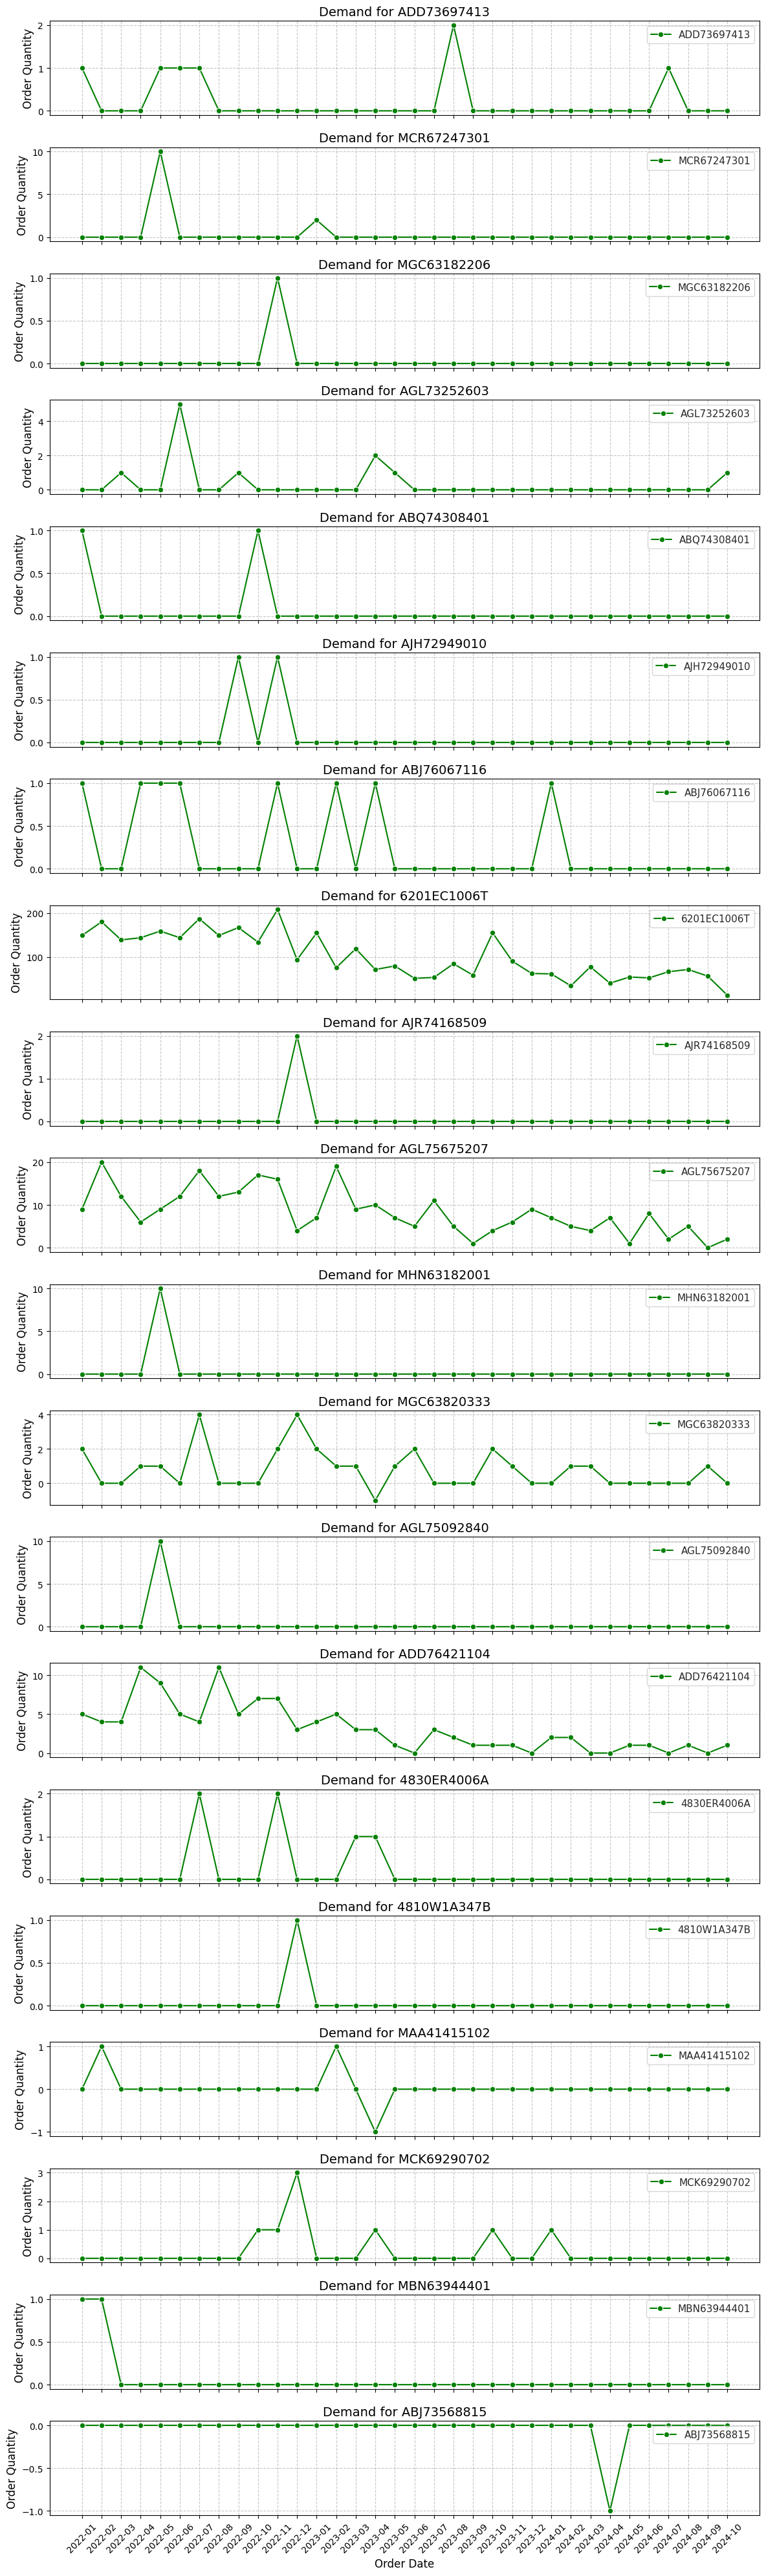

In [71]:
def create_time_series(sample_parts_no, test_data):
    n_samples = len(sample_parts_no)
    fig, axes = plt.subplots(n_samples, 1, figsize=(12, 2 * n_samples), sharex=True)

    sns.set(style='whitegrid')

    # Define a constant orange color
    orange_color = 'orange'  # You can choose any other orange color

    # Loop through each part number and plot
    for ax, part_no in zip(axes, sample_parts_no):
        part_data = test_data[test_data['Parts No'] == part_no]

        # Plot with seaborn for a better aesthetic
        sns.lineplot(x=part_data['Order Date'],
                     y=part_data['Order Qty'],
                     marker='o',
                     ax=ax,
                     label=part_no,
                     color='#008000')  # Use the constant orange color

        ax.set_title(f'Demand for {part_no}', fontsize=14)
        ax.set_ylabel('Order Quantity', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)  # Grid lines
        ax.legend()

    # Setting the x-axis label and rotating ticks
    plt.xlabel('Order Date', fontsize=12)
    plt.xticks(rotation=45)

    # Adjust the layout
    plt.tight_layout()

    return fig

# Generate the Seaborn plot
fig = create_time_series(sample_parts_no, test_data)

# Show the plot
plt.show()

In [72]:
file_name = 'gs://scm_dataset/EO_early_result/final_EO_list.csv'
final_list.to_csv(file_name, index=False)